In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from importlib import reload
import TSManager as ts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
%matplotlib inline

from CorrScreen import CorrScreenPredictor
import TSManager as ts

In [4]:
reload(ts)
mgr = ts.TSManager()
mgr.load()

Loading DP
Loading PE
Loading BM
Loading CAPE
Loading BY
Loading DEF
Loading PCAPrice
Loading CPI
Loading NOS
Loading PCR
Loading OIL
Loading SI
Loading BDI
Loading CAY
Loading IC
Loading TERM
Loading VRP
Loading SPX
Loading MA


In [5]:
df = mgr.data
df.head()

,DP,PE,BM,CAPE,BY,DEF,PCAPrice,CPI,NOS,PCR,OIL,SI,BDI,CAY,IC,TERM,VRP,SPX,MA
AsOfDate,,,,,,,,,,,,,,,,,,,
1990-06-08,0.063979,7.524271,NaN,8.978524,1.007418,0.96,3.616905,0.046737,0.016941,-1.622923,NaN,NaN,1278.0,-0.013576,NaN,0.50,7.197727,-0.012226,1
1990-06-11,0.063463,7.597792,NaN,9.051612,1.009642,0.96,3.583706,0.046737,0.016941,-1.615366,NaN,NaN,1264.0,-0.013576,NaN,0.49,5.607431,0.008140,1
1990-06-12,0.062662,7.699009,NaN,9.167251,1.009580,0.96,3.532720,0.046737,0.016941,-1.618868,NaN,NaN,1254.0,-0.013576,NaN,0.49,6.403252,0.012775,1
1990-06-13,0.062894,7.674771,NaN,9.133460,1.000056,0.96,3.547245,0.046737,0.016941,-1.625316,NaN,NaN,1243.0,-0.013576,NaN,0.47,7.793147,-0.003686,1
1990-06-14,0.063241,7.636994,NaN,9.083400,0.997689,0.96,3.569002,0.046737,0.016941,-1.620454,NaN,NaN,1232.0,-0.013576,NaN,0.46,7.665179,-0.005481,1


/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


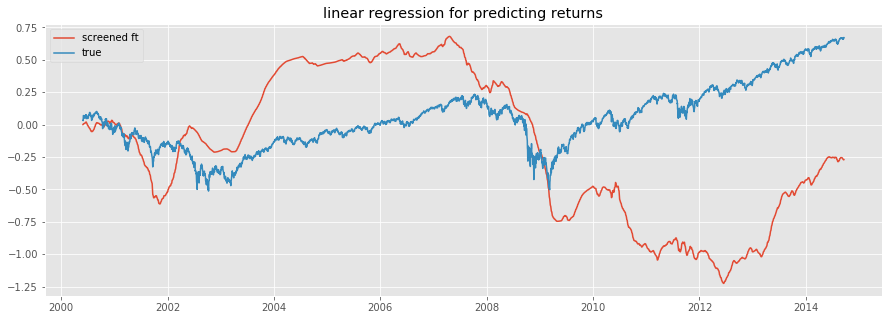

In [6]:
# test predictions

nbp = 180 # number of periods to be used
CSP = CorrScreenPredictor(df)
CSP.plot_predict(nbp)

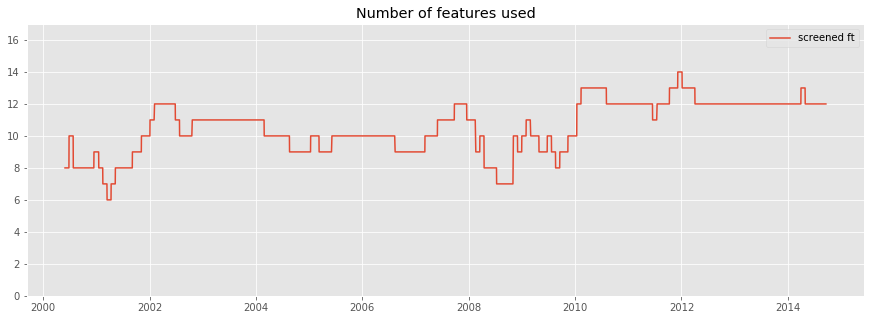

In [7]:
# plot total ft used per period

CSP.plot_screened_ft(nbp)

In [24]:
import handlers

class TradingBot:
    
    # index:             daily positions in SPX
    # update frequency:  positions are adjusted each time the return forecast change exceeds 10%
    # size:              eight times expected returns
    # caps:              strategy caped at 150% long / 50% short

    def __init__(self,data,threshold=0.1):
        self.threshold = threshold
        self.data = data
        self.X = np.array(data[[handle.NAME for handle in handlers.ALL_HANDLERS if handle.NAME != 'SPX']])
        self.y = np.array(data[['SPX']])
    
    def return_pos(self,nb_periods):
        
        CSP = CorrScreenPredictor(self.data,self.threshold)
        p,ytrue,sft = CSP.predict(nb_periods)
        
        p = [_p*100 for _p in p]
        
        plt.hist(p,bins=50)
        plt.show()
        
        
        pos = [8*p[0]]
        last_return_forecast = p[0]
        for k in range(1,len(p)):
            return_forecast = p[k]
            chg = return_forecast/last_return_forecast
            if (chg>=1.1) or (chg<=0.9):
                # change of 10% 
                last_return_forecast = return_forecast
            # take position
            pos.append(8*last_return_forecast)
            
        # cap positions
        for i in range(len(pos)):
            if pos[i]>1.5:
                pos[i]=1.5
            elif pos[i]<-0.5:
                pos[i]=-0.5
                
        return pos
    
    #def plot_wealth(self,nb_periods):
    #    
    #    
    #    pos = self.return_pos(self,nb_periods)
    #    
    #    plt.figure(figsize=(15,5))
    #    plt.plot(self.data.index[2520:(2520+nbp*20)],np.cumsum(p),label='screened ft')
    #    plt.plot(self.data.index[2520:(2520+nbp*20)],np.cumsum(ytrue),label='true')
    #    plt.title('wealth')
    #    plt.legend()
    #    plt.show()
        
            
        
        
        
    
    

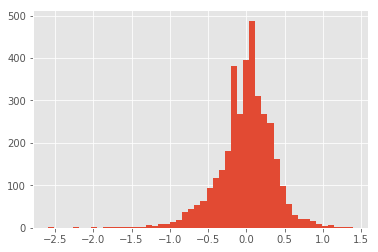

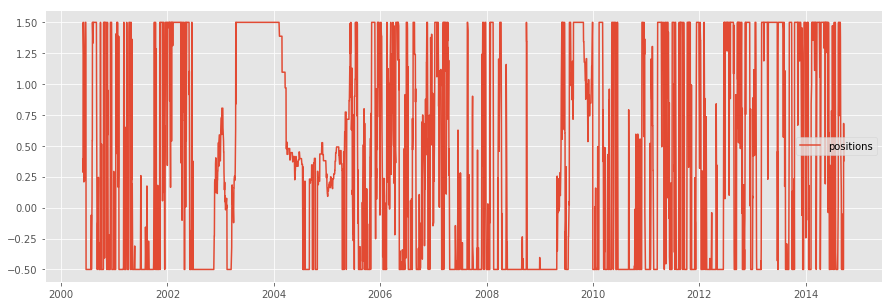

In [28]:
tb = TradingBot(df)

pos = tb.return_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

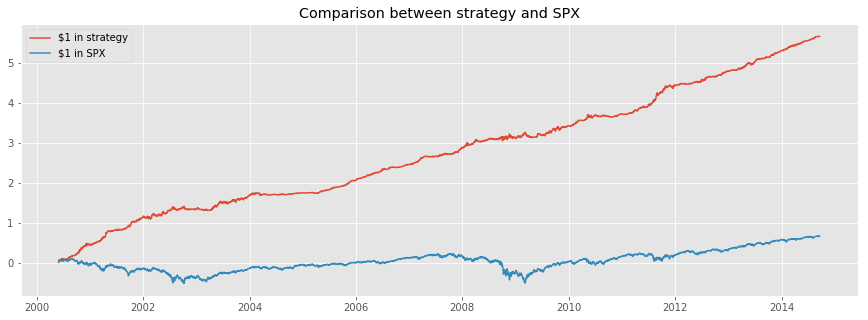

In [29]:

#sp = np.cumsum(pos).tolist()
chgs = df['SPX'][2520:(2520+nbp*20)].tolist()
#r = [sp[i]*chgs[i] for i in range(len(sp))]
r = [pos[i]*chgs[i] for i in range(len(pos))]
cr = np.cumsum(r)
#cr = [_cr+1 for _cr in cr]

cr_true = np.cumsum(chgs)
#cr_true = [_cr_true+1 for _cr_true in cr_true]

plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],cr,label='$1 in strategy')
plt.plot(df.index[2520:(2520+nbp*20)],cr_true,label='$1 in SPX')
plt.title('Comparison between strategy and SPX')
plt.legend()